In [2]:
# Install RDKit in Colab (uncomment if needed)
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 46.9 MB/s eta 0:00:00


In [3]:
# Google Colab K-means Molecular Selection
# Run this in Google Colab - all dependencies are pre-installed

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from datetime import datetime
import os
from tqdm import tqdm


from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Descriptors

def count_protonatable_sites(smiles):
    """Count number of protonatable sites using TPSA approach"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0

    # Get TPSA contribution sites (protonatable atoms)
    tpsa = Chem.rdMolDescriptors._CalcTPSAContribs(mol)
    sites = np.argwhere(np.array(tpsa) > 0).flatten().tolist()

    # Filter to only N, O, S, P atoms
    valid_sites = 0
    for atom_idx in sites:
        atom = mol.GetAtomWithIdx(atom_idx)
        if atom.GetSymbol() in ['N', 'O', 'S', 'P'] and atom.GetFormalCharge() == 0:
            valid_sites += 1

    return valid_sites

def has_target_heteroatoms(smiles):
    """Check if molecule contains N, O, S, or P atoms."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False
    symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]
    return any(x in symbols for x in ['N', 'O', 'S', 'P'])

def enhanced_molecular_screen(df, smiles_col, chunk_size=5000):
    """Screen molecules using enhanced criteria with chunked processing for speed."""

    def get_molecular_properties_batch(smiles_list):
        """Process a batch of SMILES for better performance"""
        results = []
        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                results.append([0, 0, 0, 0, False, True, True, 0])
                continue

            try:
                # Basic properties
                hbd = rdMolDescriptors.CalcNumHBD(mol)
                hba = rdMolDescriptors.CalcNumHBA(mol)
                heavy_atoms = mol.GetNumHeavyAtoms()
                mw = Descriptors.MolWt(mol)

                # Heteroatoms and charges - optimized checks
                symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]
                has_heteroatoms = any(x in symbols for x in ['N', 'O', 'S', 'P'])
                has_halogens = any(x in symbols for x in ['F', 'Cl', 'Br', 'I'])
                has_charges = any(atom.GetFormalCharge() != 0 for atom in mol.GetAtoms())

                # Protonatable sites
                protonatable_sites = count_protonatable_sites(smiles)

                results.append([hbd, hba, heavy_atoms, mw, has_heteroatoms,
                               has_halogens, has_charges, protonatable_sites])
            except:
                results.append([0, 0, 0, 0, False, True, True, 0])

        return results

    print("Calculating molecular properties in chunks...")

    # Initialize result columns
    property_columns = ['HBD', 'HBA', 'heavy_atoms', 'MW', 'has_heteroatoms',
                       'has_halogens', 'has_charges', 'protonatable_sites']

    # Process in chunks with progress bar
    total_chunks = (len(df) + chunk_size - 1) // chunk_size
    all_results = []

    for i in tqdm(range(0, len(df), chunk_size),
                  desc=f"Processing molecules (chunks of {chunk_size})",
                  total=total_chunks):
        chunk_end = min(i + chunk_size, len(df))
        smiles_chunk = df[smiles_col].iloc[i:chunk_end].tolist()

        # Process this chunk
        chunk_results = get_molecular_properties_batch(smiles_chunk)
        all_results.extend(chunk_results)

    # Convert results to DataFrame columns
    results_df = pd.DataFrame(all_results, columns=property_columns, index=df.index)

    # Add results to original DataFrame
    for col in property_columns:
        df[col] = results_df[col]

    # Apply all filters with progress indication
    print("Applying molecular filters...")
    original_len = len(df)

    # Pre-filter for speed (most restrictive first)
    print("  - Filtering by heteroatoms...")
    df = df[df['has_heteroatoms'] == True]

    print("  - Filtering by halogens and charges...")
    df = df[(df['has_halogens'] == False) & (df['has_charges'] == False)]

    print("  - Filtering by size and molecular weight...")
    df = df[(df['heavy_atoms'] >= 5) & (df['heavy_atoms'] <= 25) &
            (df['MW'] >= 50) & (df['MW'] <= 250)]

    print("  - Filtering by hydrogen bonding...")
    df = df[(df['HBD'] >= 1) & (df['HBA'] >= 1)]

    print("  - Filtering by protonatable sites...")
    filtered = df[df['protonatable_sites'] >= 2]

    print(f"Enhanced filtering: {original_len} → {len(filtered)} molecules")
    print(f"Filters applied: heteroatoms (N/O/S/P), 5-25 heavy atoms, MW 50-250, ≥2 protonatable sites, no halogens, neutral")

    return filtered

def kmeans_molecular_selection(df, n_dft=256, n_pm7_per_dft=64, smiles_col='smiles'):
    """
    K-means based selection using sklearn KMeans on full filtered dataset.

    Parameters:
    - df: DataFrame with molecular data
    - n_dft: Number of DFT calculations (cluster centers)
    - n_pm7_per_dft: Number of PM7 calculations per DFT molecule
    - smiles_col: Column name for SMILES strings

    Returns:
    - dft_df: DataFrame with DFT molecules
    - pm7_df: DataFrame with PM7 molecules (includes DFT molecules)
    - cluster_info_df: DataFrame with cluster information
    """

    print(f"Starting K-means molecular selection:")
    print(f"  - {n_dft} DFT calculations (cluster representatives)")
    print(f"  - {n_pm7_per_dft} PM7 calculations per DFT molecule")
    print(f"  - Total PM7 calculations: {n_dft * n_pm7_per_dft}")
    print(f"  - Clustering on full dataset: {len(df)} molecules")

    coords = df.loc[:, ['latent_1', 'latent_2', 'latent_3']].values

    # Step 1: K-means clustering on FULL filtered dataset using sklearn
    print(f"\nStep 1: Performing K-means clustering on all {len(df)} molecules...")
    print("  - Using sklearn KMeans with k-means++ initialization")
    print("  - This may take a few minutes for large datasets...")

    # Use sklearn KMeans with optimal settings
    kmeans = KMeans(
        n_clusters=n_dft,
        n_init=10,          # Multiple runs for robustness
        init='k-means++',   # Smart initialization
        random_state=42,    # Reproducible results
        verbose=1,          # Show progress
        max_iter=300        # Maximum iterations
    )

    cluster_labels = kmeans.fit_predict(coords)
    cluster_centers = kmeans.cluster_centers_

    print(f"  - Converged after {kmeans.n_iter_} iterations")
    print(f"  - Final inertia (within-cluster sum of squares): {kmeans.inertia_:.2f}")

    # Calculate cluster information
    cluster_info = []
    for i in range(n_dft):
        cluster_mask = cluster_labels == i
        cluster_info.append({
            'cluster_id': i,
            'centroid_latent_1': cluster_centers[i][0],
            'centroid_latent_2': cluster_centers[i][1],
            'centroid_latent_3': cluster_centers[i][2],
            'n_molecules_in_cluster': np.sum(cluster_mask)
        })

    cluster_info_df = pd.DataFrame(cluster_info)

    print(f"Created {len(cluster_centers)} clusters from full dataset")
    print(f"Average cluster size: {len(df) / len(cluster_centers):.1f} molecules")
    print(f"Cluster size range: {cluster_info_df['n_molecules_in_cluster'].min()} - {cluster_info_df['n_molecules_in_cluster'].max()}")

    # Step 2: Select DFT molecules (closest to each cluster center)
    print(f"\nStep 2: Selecting DFT molecules (closest to cluster centers)...")
    dft_molecules = []
    dft_indices = []
    distances_to_centroid = []

    for i in tqdm(range(len(cluster_centers)), desc="Finding DFT molecules"):
        cluster_mask = cluster_labels == i
        if not np.any(cluster_mask):
            continue

        cluster_coords = coords[cluster_mask]
        cluster_df_indices = df.index[cluster_mask].tolist()
        centroid = cluster_centers[i]

        # Find molecule closest to centroid
        distances = np.linalg.norm(cluster_coords - centroid, axis=1)
        closest_idx = np.argmin(distances)
        closest_original_idx = cluster_df_indices[closest_idx]

        dft_molecules.append(closest_original_idx)
        dft_indices.append(i)
        distances_to_centroid.append(distances[closest_idx])

    # Create DFT DataFrame
    dft_df = df.loc[dft_molecules].copy()
    dft_df['calculation_type'] = 'DFT'
    dft_df['cluster_id'] = dft_indices
    dft_df['is_cluster_center'] = True
    dft_df['distance_to_centroid'] = distances_to_centroid

    # Add centroid coordinates to DFT DataFrame
    dft_df = dft_df.merge(cluster_info_df[['cluster_id', 'centroid_latent_1', 'centroid_latent_2', 'centroid_latent_3']],
                         on='cluster_id', how='left')

    print(f"Selected {len(dft_df)} DFT molecules")
    print(f"Average distance DFT to centroid: {np.mean(distances_to_centroid):.4f}")

    # Step 3: For each DFT molecule, select nearby PM7 molecules
    print(f"\nStep 3: Selecting {n_pm7_per_dft} PM7 molecules around each DFT molecule...")

    pm7_molecules = []

    for i, dft_idx in enumerate(tqdm(dft_molecules, desc="Selecting PM7 molecules")):
        cluster_id = dft_indices[i]
        cluster_mask = cluster_labels == cluster_id
        cluster_df_indices = df.index[cluster_mask].tolist()
        cluster_coords = coords[cluster_mask]

        # Get the DFT molecule coordinates
        dft_coords = coords[df.index == dft_idx][0]

        # Calculate distances from DFT molecule to all molecules in its cluster
        distances = np.linalg.norm(cluster_coords - dft_coords, axis=1)

        # Select closest n_pm7_per_dft molecules (including the DFT molecule itself)
        n_select = min(n_pm7_per_dft, len(cluster_coords))
        closest_indices = np.argsort(distances)[:n_select]
        selected_original_indices = [cluster_df_indices[idx] for idx in closest_indices]

        for j, orig_idx in enumerate(selected_original_indices):
            pm7_molecules.append({
                'original_index': orig_idx,
                'cluster_id': cluster_id,
                'dft_representative': dft_idx,
                'distance_to_dft': distances[closest_indices[j]],
                'distance_to_centroid': np.linalg.norm(coords[df.index == orig_idx][0] - cluster_centers[cluster_id]),
                'is_cluster_center': orig_idx == dft_idx
            })

    # Create PM7 DataFrame
    pm7_data = pd.DataFrame(pm7_molecules)
    pm7_df = df.loc[pm7_data['original_index']].copy()
    pm7_df['calculation_type'] = 'PM7'
    pm7_df['cluster_id'] = pm7_data['cluster_id'].values
    pm7_df['dft_representative'] = pm7_data['dft_representative'].values
    pm7_df['distance_to_dft'] = pm7_data['distance_to_dft'].values
    pm7_df['distance_to_centroid'] = pm7_data['distance_to_centroid'].values
    pm7_df['is_cluster_center'] = pm7_data['is_cluster_center'].values

    # Add centroid coordinates to PM7 DataFrame
    pm7_df = pm7_df.merge(cluster_info_df[['cluster_id', 'centroid_latent_1', 'centroid_latent_2', 'centroid_latent_3']],
                         on='cluster_id', how='left')

    # Reset indices
    dft_df = dft_df.reset_index(drop=True)
    pm7_df = pm7_df.reset_index(drop=True)

    print(f"Selected {len(pm7_df)} PM7 molecules total")
    print(f"  - {len(pm7_df[pm7_df['is_cluster_center']])} are also DFT molecules")
    print(f"  - {len(pm7_df[~pm7_df['is_cluster_center']])} are PM7-only molecules")

    return dft_df, pm7_df, cluster_info_df

def has_nitrogen(smiles):
    """Check if a SMILES string contains a nitrogen atom."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False
    return any(atom.GetSymbol() == 'N' for atom in mol.GetAtoms())

def screen_molecules_for_hbd_hba(df, smiles_col):
    """Screen molecules for having at least 1 hydrogen bond donor and 1 hydrogen bond acceptor."""
    def count_hbd_hba(smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return 0, 0
        hbd = rdMolDescriptors.CalcNumHBD(mol)
        hba = rdMolDescriptors.CalcNumHBA(mol)
        return hbd, hba

    df[['HBD', 'HBA']] = df.apply(lambda row: pd.Series(count_hbd_hba(row[smiles_col])), axis=1)
    filtered = df[(df['HBD'] >= 1) & (df['HBA'] >= 1)]
    print(f"HBD/HBA filtering: {len(df)} → {len(filtered)} molecules")
    return filtered

def main():
    # For Colab - upload your CSV file or modify this path
    print("Upload your CSV file to Colab or modify the file path below:")

    # Option 1: Upload file in Colab
    from google.colab import files
    print("Uploading file...")
    uploaded = files.upload()
    fname = list(uploaded.keys())[0]  # Use uploaded filename

    # Option 2: Use Google Drive (uncomment if your file is in Drive)
    # from google.colab import drive
    # drive.mount('/content/drive')
    # fname = '/content/drive/MyDrive/your_file.csv'

    # Option 3: Direct path (uncomment and modify)
    # fname = 'StructureEmbeddingMany-TransformMorganFingerprints-WriteAllMorganFingerprints-ConcatCSV-2D-AK-AKEC-009.csv'

    df = pd.read_csv(fname)

    # K-means selection parameters
    n_dft = 256  # Number of DFT calculations (cluster centers)
    n_pm7_per_dft = 64  # Number of PM7 calculations per DFT molecule
    use_enhanced_filters = True
    chunk_size = 5000  # Chunk size for property calculations

    print(f"Starting with {len(df)} molecules")

    # Apply molecular filters
    if use_enhanced_filters:
        print("Using enhanced filtering (heteroatoms N/O/S/P, size, protonatable sites)...")
        filtered_df = enhanced_molecular_screen(df, 'smiles', chunk_size=chunk_size)
    else:
        print("Using original filtering (Nitrogen + HBD/HBA)...")
        filtered_df = screen_molecules_for_hbd_hba(df[df['smiles'].apply(has_nitrogen)], 'smiles')

    if len(filtered_df) == 0:
        print("No molecules passed filters. Consider relaxing criteria.")
        return

    print(f"After filtering: {len(filtered_df)} molecules available for selection")

    # Adjust parameters if we have fewer molecules than requested
    total_requested = n_dft * n_pm7_per_dft
    if len(filtered_df) < total_requested:
        print(f"Warning: Only {len(filtered_df)} molecules available, but {total_requested} requested")
        print("Consider reducing n_dft or n_pm7_per_dft parameters")

    # Perform K-means selection
    dft_df, pm7_df, cluster_info_df = kmeans_molecular_selection(
        filtered_df, n_dft=n_dft, n_pm7_per_dft=n_pm7_per_dft, smiles_col='smiles'
    )

    # Save results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filter_type = "enhanced" if use_enhanced_filters else "original"

    # Save cluster information
    cluster_output = f'clusters_{filter_type}_{n_dft}clusters_{timestamp}.csv'
    cluster_info_df.to_csv(cluster_output, index=False)

    # Save DFT molecules
    dft_output = f'DFT_{filter_type}_{len(dft_df)}molecules_{timestamp}.csv'
    dft_df.to_csv(dft_output, index=False)

    # Save PM7 molecules
    pm7_output = f'PM7_{filter_type}_{len(pm7_df)}molecules_{timestamp}.csv'
    pm7_df.to_csv(pm7_output, index=False)

    # Save combined file with calculation type information
    combined_df = pd.concat([dft_df, pm7_df[~pm7_df['is_cluster_center']]], ignore_index=True)
    combined_output = f'hierarchical_{filter_type}_{len(combined_df)}molecules_{timestamp}.csv'
    combined_df.to_csv(combined_output, index=False)

    print(f"\nResults saved:")
    print(f"  - Cluster info: {cluster_output}")
    print(f"  - DFT molecules: {dft_output}")
    print(f"  - PM7 molecules: {pm7_output}")
    print(f"  - Combined file: {combined_output}")

    # Summary statistics
    print(f"\nSummary:")
    print(f"  - {len(cluster_info_df)} K-means clusters")
    print(f"  - {len(dft_df)} DFT calculations")
    print(f"  - {len(pm7_df)} PM7 calculations")
    print(f"  - Average PM7 molecules per DFT: {len(pm7_df) / len(dft_df):.1f}")
    print(f"  - Unique molecules total: {len(combined_df)}")
    print(f"  - Average distance DFT to centroid: {dft_df['distance_to_centroid'].mean():.3f}")
    print(f"  - Max distance DFT to centroid: {dft_df['distance_to_centroid'].max():.3f}")
    print(f"  - Average cluster size: {cluster_info_df['n_molecules_in_cluster'].mean():.1f}")

    # Download results (Colab specific)
    files.download(dft_output)
    files.download(pm7_output)
    files.download(combined_output)
    files.download(cluster_output)

    return dft_df, pm7_df, cluster_info_df

if __name__ == "__main__":
    main()

Upload your CSV file to Colab or modify the file path below:
Uploading file...


Saving StructureEmbeddingMany-TransformMorganFingerprints-WriteAllMorganFingerprints-ConcatCSV-2D-AK-AKEC-009.csv to StructureEmbeddingMany-TransformMorganFingerprints-WriteAllMorganFingerprints-ConcatCSV-2D-AK-AKEC-009.csv
Starting with 1301790 molecules
Using enhanced filtering (heteroatoms N/O/S/P, size, protonatable sites)...
Calculating molecular properties in chunks...


Processing molecules (chunks of 5000): 100%|██████████| 261/261 [11:06<00:00,  2.55s/it]


Applying molecular filters...
  - Filtering by heteroatoms...
  - Filtering by halogens and charges...
  - Filtering by size and molecular weight...
  - Filtering by hydrogen bonding...
  - Filtering by protonatable sites...
Enhanced filtering: 1301790 → 821435 molecules
Filters applied: heteroatoms (N/O/S/P), 5-25 heavy atoms, MW 50-250, ≥2 protonatable sites, no halogens, neutral
After filtering: 821435 molecules available for selection
Starting K-means molecular selection:
  - 256 DFT calculations (cluster representatives)
  - 64 PM7 calculations per DFT molecule
  - Total PM7 calculations: 16384
  - Clustering on full dataset: 821435 molecules

Step 1: Performing K-means clustering on all 821435 molecules...
  - Using sklearn KMeans with k-means++ initialization
  - This may take a few minutes for large datasets...
Initialization complete
Iteration 0, inertia 397368.76746979833.
Iteration 1, inertia 367832.99724682857.
Iteration 2, inertia 359445.8614432745.
Iteration 3, inertia 35

Finding DFT molecules: 100%|██████████| 256/256 [00:00<00:00, 306.87it/s]


Selected 256 DFT molecules
Average distance DFT to centroid: 0.0563

Step 3: Selecting 64 PM7 molecules around each DFT molecule...


Selecting PM7 molecules: 100%|██████████| 256/256 [00:42<00:00,  5.97it/s]


Selected 16384 PM7 molecules total
  - 256 are also DFT molecules
  - 16128 are PM7-only molecules

Results saved:
  - Cluster info: clusters_enhanced_256clusters_20250903_222036.csv
  - DFT molecules: DFT_enhanced_256molecules_20250903_222036.csv
  - PM7 molecules: PM7_enhanced_16384molecules_20250903_222036.csv
  - Combined file: hierarchical_enhanced_16384molecules_20250903_222036.csv

Summary:
  - 256 K-means clusters
  - 256 DFT calculations
  - 16384 PM7 calculations
  - Average PM7 molecules per DFT: 64.0
  - Unique molecules total: 16384
  - Average distance DFT to centroid: 0.056
  - Max distance DFT to centroid: 0.203
  - Average cluster size: 3208.7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plot the candidates selected

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings

warnings.filterwarnings('ignore')

def plot_chemical_latent_space(fname, dft_df, pm7_df, save_path=None,
                              fig_size=(24, 8), font_size=14,
                              background_alpha=0.85, # CHANGED: Increased opacity
                              point_size=60,
                              show_density=True, density_gridsize=50):
    """
    Create an enhanced, horizontal visualization of chemical latent space showing:
    1. Background: Full chemical space with a strong, vibrant density plot.
    2. Foreground: DFT molecules (orange squares) and PM7 molecules (purple circles).
    3. Three subplots: Latent1 vs Latent2, Latent2 vs Latent3, Latent1 vs Latent3.
    """

    # Set modern aesthetic style
    plt.style.use('default')
    sns.set_style("whitegrid")

    # Load background chemical space data
    background_df = pd.read_csv(fname)

    # Create figure with 3 horizontal subplots
    fig, axes = plt.subplots(1, 3, figsize=fig_size, facecolor='white')
    fig.patch.set_facecolor('white')

    # Define high-contrast color scheme
    colors = {
        'dft': '#FF6347',           # Bright Orange/Tomato for DFT
        'pm7': '#8A2BE2',           # Deep Purple for PM7
        'background_cmap': 'plasma', # CHANGED: Switched to a more vibrant colormap
        'grid': '#D3D3D3'
    }

    # Define subplot configurations
    subplot_configs = [
        {'coords': ['latent_2', 'latent_1'], 'title': 'Latent Dim 2 vs Latent Dim 1'},
        {'coords': ['latent_3', 'latent_2'], 'title': 'Latent Dim 3 vs Latent Dim 2'},
        {'coords': ['latent_3', 'latent_1'], 'title': 'Latent Dim 3 vs Latent Dim 1'}
    ]

    # Plot each latent space combination
    for i, config in enumerate(subplot_configs):
        ax = axes[i]
        x_col, y_col = config['coords']

        # Extract coordinates
        bg_coords = background_df[[x_col, y_col]].values
        dft_coords = dft_df[[x_col, y_col]].values
        pm7_coords = pm7_df[[x_col, y_col]].values

        # Plot background chemical space density
        if show_density:
            hb = ax.hexbin(bg_coords[:, 0], bg_coords[:, 1],
                          gridsize=density_gridsize,
                          cmap=colors['background_cmap'],
                          alpha=background_alpha, # Using the new, higher alpha
                          mincnt=1)
        else:
            ax.scatter(bg_coords[:, 0], bg_coords[:, 1],
                      s=5, alpha=0.3, color='#ADD8E6',
                      label='Background Chemical Space')

        # Plot PM7 molecules as transparent purple circles
        pm7_scatter = ax.scatter(pm7_coords[:, 0], pm7_coords[:, 1],
                               s=point_size,
                               facecolors=colors['pm7'],
                               edgecolors='white', # White edges for better visibility on dark bg
                               linewidths=0.5,
                               alpha=0.4,
                               label=f'PM7 Molecules (n={len(pm7_df)})',
                               marker='o',
                               zorder=4)

        # Plot DFT molecules as opaque orange squares
        dft_scatter = ax.scatter(dft_coords[:, 0], dft_coords[:, 1],
                               s=point_size + 10,
                               facecolors=colors['dft'],
                               edgecolors='black',
                               linewidths=1.0,
                               alpha=1.0,
                               label=f'DFT Molecules (n={len(dft_df)})',
                               marker='s',
                               zorder=5)

        # Styling
        ax.set_xlabel(f'{x_col.replace("_", " ").title()}',
                     fontsize=font_size, fontweight='600')
        ax.set_ylabel(f'{y_col.replace("_", " ").title()}',
                     fontsize=font_size, fontweight='600')
        ax.set_title(config['title'], fontsize=font_size+2, fontweight='bold', pad=15)
        ax.grid(True, alpha=0.3, color=colors['grid'], linestyle='--') # Made grid fainter
        ax.set_facecolor('#F8F8F8')
        ax.tick_params(axis='both', labelsize=font_size-1)
        ax.set_aspect('equal', adjustable='box')


    # Add a single, shared legend outside the plots
    fig.legend(handles=[dft_scatter, pm7_scatter],
             fontsize=font_size,
             loc='upper right',
             bbox_to_anchor=(0.98, 0.93),
             frameon=True, fancybox=True, shadow=True,
             facecolor='white', framealpha=0.9)

    # Add overall title
    fig.suptitle('Chemical Latent Space Analysis: DFT vs PM7 Selections',
                 fontsize=font_size+6, fontweight='bold', y=0.98)

    # Add a single colorbar for density
    #if show_density:
        #divider = make_axes_locatable(axes[2])
        #cax = divider.append_axes("right", size="5%", pad=0.1)
        #cbar = plt.colorbar(hb, cax=cax)
        #cbar.set_label('Molecule Density in Chemical Space', fontsize=font_size, fontweight='600')
        #cbar.ax.tick_params(labelsize=font_size-2)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, right=0.92)

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Plot saved to: {save_path}")

    plt.show()

    # Print summary statistics
    total_bg = len(background_df)
    total_dft = len(dft_df)
    total_pm7 = len(pm7_df)
    print("\n" + "="*60)
    print("CHEMICAL LATENT SPACE ANALYSIS SUMMARY")
    print("="*60)
    print(f"Background chemical space: {total_bg:,} molecules")
    print(f"DFT molecules (orange squares): {total_dft:,} ({(total_dft/total_bg)*100:.2f}% coverage)")
    print(f"PM7 molecules (purple circles): {total_pm7:,} ({(total_pm7/total_bg)*100:.2f}% coverage)")
    print("="*60)

Plot saved to: /content/latent_space_analysis.png


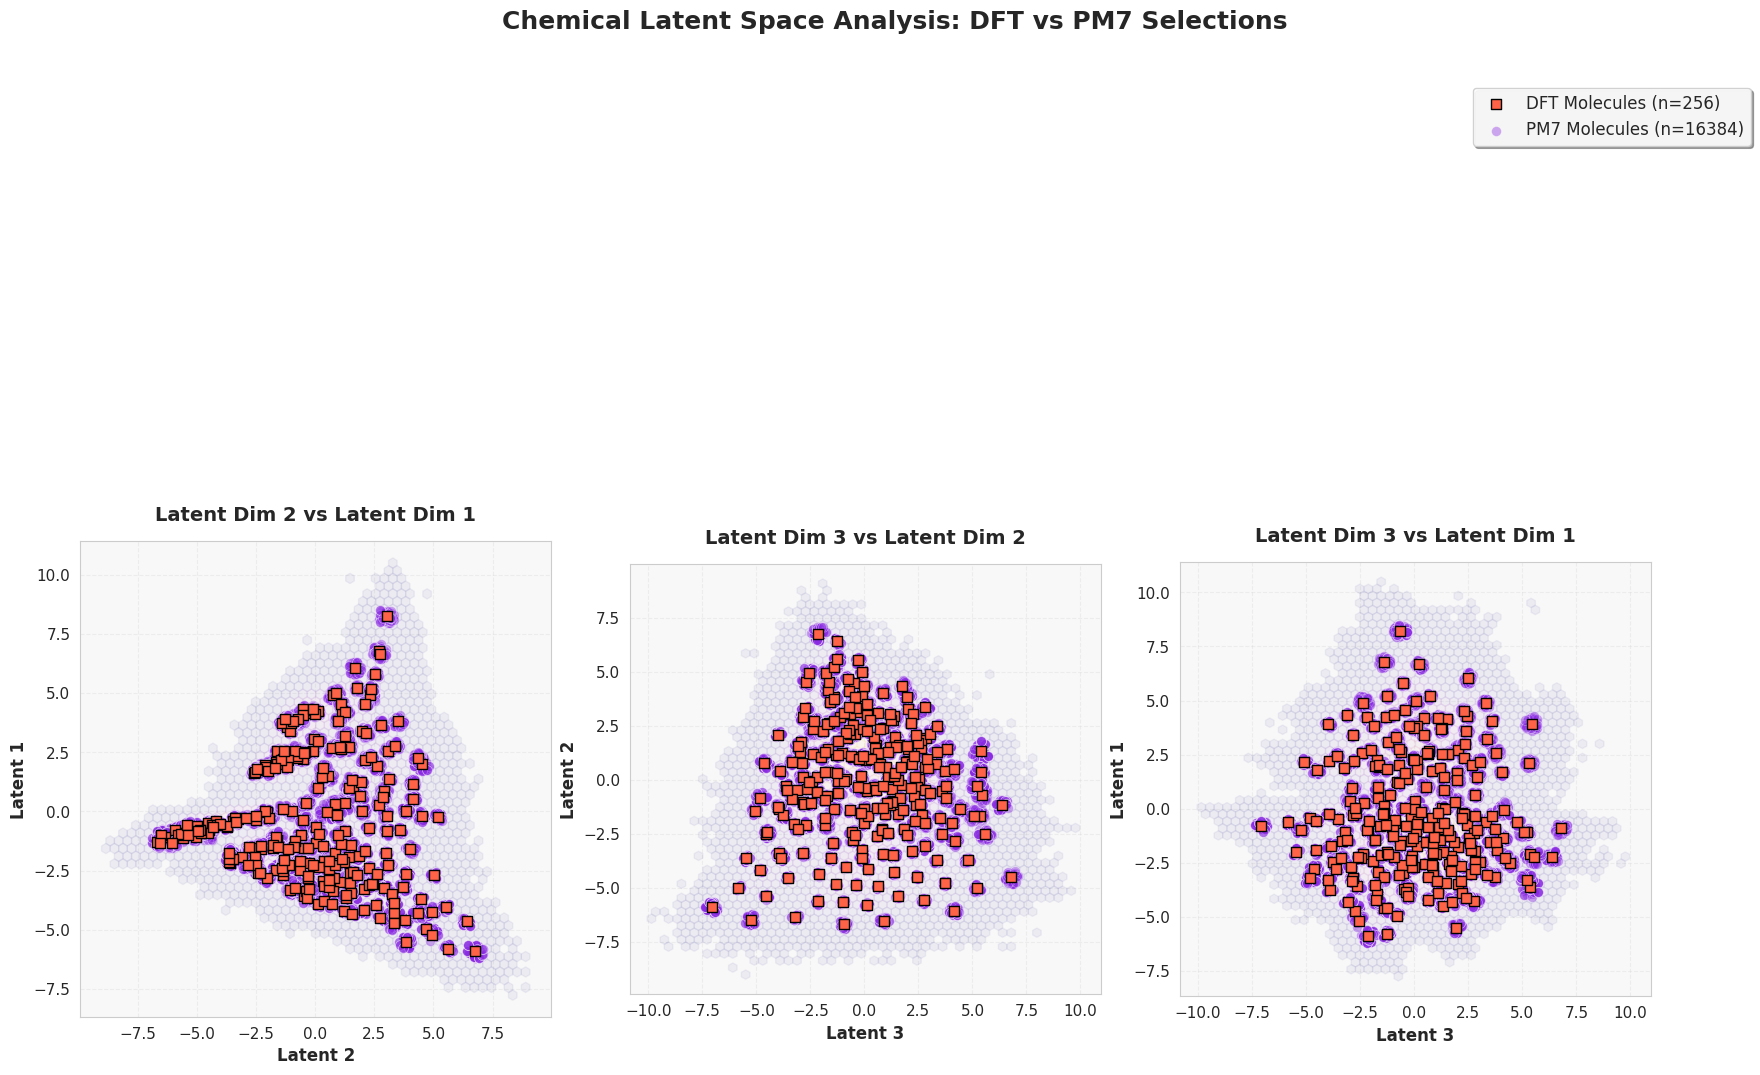


CHEMICAL LATENT SPACE ANALYSIS SUMMARY
Background chemical space: 1,301,790 molecules
DFT molecules (orange squares): 256 (0.02% coverage)
PM7 molecules (purple circles): 16,384 (1.26% coverage)


In [24]:

# Auto-detect and load files
csv_files = [f for f in os.listdir('/content/') if f.endswith('.csv')]
largest_file = max(csv_files, key=lambda x: os.path.getsize(f'/content/{x}'))
fname = f'/content/{largest_file}'

# Find DFT and PM7 files (look for keywords in filename)
dft_df = pd.read_csv(f'/content/{[f for f in csv_files if "dft" in f.lower()][0]}')
pm7_df = pd.read_csv(f'/content/{[f for f in csv_files if "pm7" in f.lower()][0]}')

# Run visualization
plot_chemical_latent_space(fname, dft_df, pm7_df,
                           save_path='/content/latent_space_analysis.png',
                           fig_size=(18, 14),
                           font_size=12,
                           background_alpha=0.05,
                           point_size=50,
                           show_density=True)